PyTorch Dataset: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

NOTE:
1. The validation range is changed to small size for debug.
2. Mean:  [0.90960454 0.81946206 0.87811487]
   Std:  [0.13244118 0.24944844 0.16392948]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import os
import pandas as pd
from skimage import io, transform
import numpy as np
import copy

import matplotlib.pyplot as plt

#import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

import time
from collections import defaultdict

In [2]:
image_cropped_dir = '../yi_data/train_crop_128'
NUM_TRAIN = 6800 #8492

USE_GPU = False
dtype = torch.float32   # use float throughout the training
print_every = 100

SCALE_SZ = 128
BATCH_SZ = 8

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cpu


In [3]:
# Customized Dataset
class ProstateCancerDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.cancer_df = pd.read_csv(csv_file).sample(frac=1, random_state=1)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.cancer_df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, f'{self.cancer_df.iloc[idx, 0]}_0.png')
        # (D,W,H)
        img = io.imread(img_path)
        isup = self.cancer_df.iloc[idx, 2]
        gleason = self.cancer_df.iloc[idx, 3]
        
        if self.transform:
            img = self.transform(img)
        sample = {'image': img, 'isup_grade': isup, 'gleason_score': gleason}
        return sample        

##Customize Transforms
class Rescale(object):
    """Rescale the image sample to the given size
    Args:
        output_size (tuple): Desired output size. Output is matched to output_size.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        
    def __call__(self, sample):
        img = transform.resize(sample['image'], self.output_size)
        return {'image': img, 'isup_grade': sample['isup_grade'], 'gleason_score': sample['gleason_score']}
    
"""
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        img = sample['image']        
        # Swap color axis to [C,H,W]
        img = img.transpose(2,0,1)
        return {'image': img, 'isup_grade': sample['isup_grade'], 'gleason_score': sample['gleason_score']}
"""

# Data Preparation

In [4]:
# Compse tranforms of totensor
# More transformer to try: crop, normalize, etc.
# And transformer is a useful tool for data augmentation
biopsy_train = ProstateCancerDataset(csv_file='train_512.csv',
                                     root_dir=image_cropped_dir,
                                     transform=T.Compose([
                                                 T.ToTensor(),
                                                 T.Normalize((0.90960454,0.81946206,0.87811487),
                                                             (0.13244118,0.24944844,0.16392948)),
                                     ]))

loader_train = DataLoader(biopsy_train, batch_size=BATCH_SZ, num_workers=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(biopsy_train, batch_size=BATCH_SZ, num_workers=4,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 8492)))  #NUM_TRAIN+200  Use smaller size for debug

isup_distr = defaultdict(int)
for batch_i, batch_sample in enumerate(loader_train):
    #for grade in batch_sample['isup_grade']:
        #print(int(grade))
    #    isup_distr[int(grade)] += 1
    print(batch_sample['image'][0].shape)
    #for s_i, sample in enumerate(batch_sample['isup_grade']):
    #    print(sample)
    print(batch_sample['isup_grade'])
    print(batch_sample['image'][0])
    plt.imshow(batch_sample['image'][0].permute(1,2,0))
    assert False
print(isup_distr)

# Two-Layer Network

In [31]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for batch in loader:
            x = batch['image'].to(device=device, dtype=dtype)
            y = batch['isup_grade'].to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds==y).sum()
            num_samples += preds.size(0)
            #print(batch['isup_grade'].unique(), batch['isup_grade'][preds==y].unique())
            #print(batch['isup_grade'])
        acc = float(num_correct) / num_samples
        print('Got {:d}/{:d} correct {:.2f}'.format(num_correct, num_samples, acc*100))

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

def train_sequential(model, optimizer, scheduler, epochs=1):
    """
    Train a model using PyTorch Sequential API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model.
    - epochs: The expected usage number of each image.
    
    Output: Print model accuracies.
    """
    model = model.to(device=device)
    for e in range(epochs):
        print(f'Epoch {e}')
        for t, batch in enumerate(loader_train):
            x = batch['image'].to(device=device, dtype=dtype)
            y = batch['isup_grade'].to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            # Backward pass: compute the gradient of the loss with respect to
            # each parameter of the model.
            loss.backward()
            
            # Update the parameters of the model using the gradients computed by
            # the backward pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration {:d}, loss = {:.4f}'.format(t, loss.item()))
                check_accuracy(loader_val, model)
                # Decay learning rate after each validation check
        scheduler.step()

In [33]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
hidden_layer_size = 100
learning_rate = 3e-3

model = nn.Sequential(
    Flatten(),
    nn.Linear(3*SCALE_SZ*SCALE_SZ, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 6)
)

# Use Nesterov momentum
"""
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=.9,
                      nesterov=True)
"""
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# Learning Rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

#train_sequential(model, optimizer, scheduler, 30)

Epoch 0
Iteration 0, loss = 1.7992
Got 436/1692 correct 25.77
Iteration 100, loss = 2.9562
Got 453/1692 correct 26.77
Epoch 1
Iteration 0, loss = 1.9555
Got 443/1692 correct 26.18
Iteration 100, loss = 1.6102
Got 450/1692 correct 26.60
Epoch 2
Iteration 0, loss = 2.2169
Got 452/1692 correct 26.71
Iteration 100, loss = 1.5697
Got 454/1692 correct 26.83
Epoch 3
Iteration 0, loss = 1.6583
Got 450/1692 correct 26.60
Iteration 100, loss = 1.7210
Got 459/1692 correct 27.13
Epoch 4
Iteration 0, loss = 1.5495
Got 460/1692 correct 27.19
Iteration 100, loss = 1.5922
Got 463/1692 correct 27.36
Epoch 5
Iteration 0, loss = 1.5628
Got 461/1692 correct 27.25
Iteration 100, loss = 1.5773
Got 461/1692 correct 27.25
Epoch 6
Iteration 0, loss = 1.5719
Got 461/1692 correct 27.25
Iteration 100, loss = 1.6990
Got 463/1692 correct 27.36
Epoch 7
Iteration 0, loss = 1.6314
Got 463/1692 correct 27.36
Iteration 100, loss = 1.5721
Got 464/1692 correct 27.42
Epoch 8
Iteration 0, loss = 1.6030
Got 464/1692 correct 

# CNN
Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
                
            running_loss = 0.0
            running_corrects = 0
            
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device=device, dtype=dtype)
                labels = batch['isup_grade'].to(device=device, dtype=torch.long)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                #print(loss.item())
                running_corrects += torch.sum(preds == labels)
            
            # End of epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:4f} Acc: {:4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)
                
            if scheduler is not None and phase == 'train':
                scheduler.step()
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, train_acc_history, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(num_classes, feature_extract=False, use_pretrained=False):
    model_ft = None
    input_size = 0
    
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    #input_size = 128
    
    return model_ft, input_size

In [7]:
model_ft, input_size = initialize_model(6)
#print(model_ft)
# Send the model to GPU/CPU
model_ft = model_ft.to(device)

optimizer = optim.SGD(model_ft.parameters(),
                      lr=3e-3,
                      momentum=.9,
                      nesterov=True)

best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, None, 30)
print(loss_history)
print(train_acc_history)
print(val_acc_history)

Epoch 0/29
----------
train Loss: 1.362890 Acc: 0.214555
val Loss: 0.332934 Acc: 0.055817

Epoch 1/29
----------
train Loss: 1.311477 Acc: 0.234691
val Loss: 0.314514 Acc: 0.065120

Epoch 2/29
----------
train Loss: 1.290490 Acc: 0.248234
val Loss: 0.344744 Acc: 0.051225

Epoch 3/29
----------
train Loss: 1.268827 Acc: 0.266251
val Loss: 0.324312 Acc: 0.066415

Epoch 4/29
----------
train Loss: 1.258370 Acc: 0.272138
val Loss: 0.360057 Acc: 0.039331

Epoch 5/29
----------
train Loss: 1.251786 Acc: 0.275553
val Loss: 0.306454 Acc: 0.072068

Epoch 6/29
----------
train Loss: 1.237759 Acc: 0.286387
val Loss: 0.308663 Acc: 0.069948

Epoch 7/29
----------
train Loss: 1.228292 Acc: 0.282854
val Loss: 0.307566 Acc: 0.071008

Epoch 8/29
----------
train Loss: 1.210777 Acc: 0.298045
val Loss: 0.315462 Acc: 0.070537

Epoch 9/29
----------
train Loss: 1.205048 Acc: 0.300871
val Loss: 0.305038 Acc: 0.071715

Epoch 10/29
----------
train Loss: 1.189986 Acc: 0.308526
val Loss: 0.304645 Acc: 0.074894

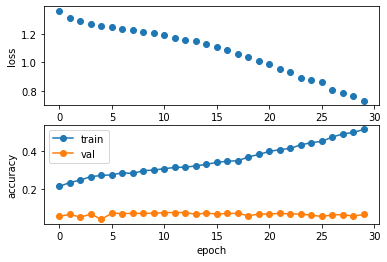

In [8]:
"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(loss_history, 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [9]:
print(best_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 